In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

2023-05-11 21:47:01.699174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 21:47:01.722896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-11 21:47:01.723404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 21:47:02.337238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
cnn_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
cnn_base.trainable = False

cnn = keras.models.Sequential()
cnn.add(cnn_base)
cnn.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(128, activation='relu'))
cnn.add(keras.layers.Dropout(0.4))
cnn.add(keras.layers.Dense(5, activation='softmax'))

In [24]:
cnn_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][

In [25]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_1 (Averag  (None, 2, 2, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               655488    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [73]:
opt = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)

cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
from keras.preprocessing.image import ImageDataGenerator

image_size = (100, 100)

db_dir = './tf_flowers'

data_gen_augm = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen_augm.flow_from_directory(
    db_dir + '/train',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_gen = data_gen.flow_from_directory(
    db_dir + '/validation',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_gen = data_gen.flow_from_directory(
    db_dir + '/test',
    target_size=image_size,
    batch_size=100,
    class_mode='categorical',
    shuffle=False
)

for data_batch, labels_batch in train_gen:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


Found 1835 images belonging to 5 classes.
Found 735 images belonging to 5 classes.
Found 1100 images belonging to 5 classes.
data batch shape: (32, 100, 100, 3)
labels batch shape: (32, 5)


In [110]:

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True,
                                                   save_weights_only=True, monitor='val_loss', mode='min')
train = cnn.fit(
    train_gen,
    steps_per_epoch=20,
    epochs=50,
    validation_data=valid_gen,
    validation_steps=10,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/50
 1/20 [>.............................] - ETA: 2s - loss: 0.4863 - accuracy: 0.8750

2023-05-11 22:31:47.177564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8625

2023-05-11 22:31:49.962638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.68020, saving model to best_model.h5
20/20 [==============================] - 4s 194ms/step - loss: 0.3495 - accuracy: 0.8625 - val_loss: 0.6802 - val_accuracy: 0.8406
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8875
Epoch 2: val_loss improved from 0.68020 to 0.53020, saving model to best_model.h5
20/20 [==============================] - 4s 183ms/step - loss: 0.3568 - accuracy: 0.8875 - val_loss: 0.5302 - val_accuracy: 0.8500
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8687
Epoch 3: val_loss did not improve from 0.53020
20/20 [==============================] - 4s 179ms/step - loss: 0.3435 - accuracy: 0.8687 - val_loss: 0.5319 - val_accuracy: 0.8375
Epoch 4/50
19/20 [===========================>..] - ETA: 0s - loss: 0.3913 - accuracy: 0.8618
Epoch 4: val_loss improved from 0.53020 to 0.52734, saving model to best_model.h5
20/20 [============================

In [111]:
cnn.load_weights('best_model.h5')

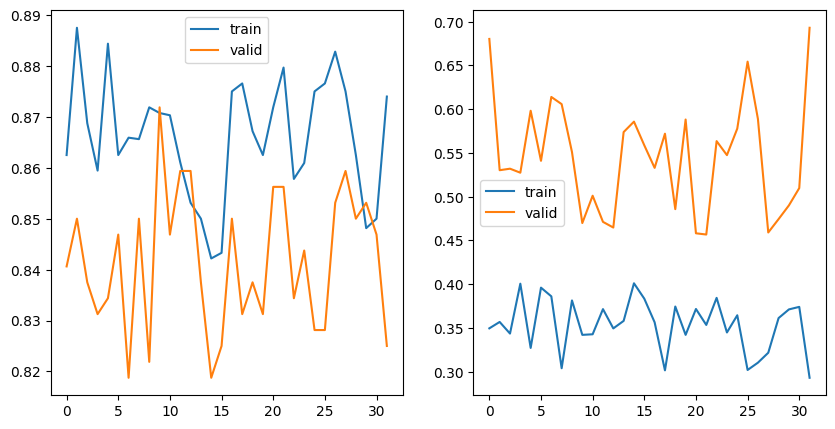

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='train')
plt.plot(train.history['val_accuracy'], label='valid')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='train')
plt.plot(train.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [113]:
test_gen.reset()
pred = cnn.predict(test_gen, steps=11)
pred = np.argmax(pred, axis=1)


2023-05-11 22:33:46.109904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


11/11 [==============================] - 5s 435ms/step


In [114]:
print(pred)
print(np.sum(pred != test_gen.classes))

[0 0 0 ... 4 4 4]
191


In [115]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_gen.classes, pred)

array([[145,  19,   7,   6,  13],
       [  3, 238,   2,  23,   3],
       [ 11,   5, 143,   6,  28],
       [  1,   9,   3, 188,   8],
       [  4,   6,  24,  10, 195]])

In [117]:
# print number of errors of total
print(np.sum(pred != test_gen.classes), 'errors of', len(test_gen.classes), 'total')
# print percentage of errors
print(np.sum(pred != test_gen.classes) / len(test_gen.classes) * 100, '% errors')
# print accuracy
print((len(test_gen.classes) - np.sum(pred != test_gen.classes)) / len(test_gen.classes) * 100, '% accuracy')

191 errors of 1100 total
17.363636363636363 % errors
82.63636363636364 % accuracy


In [118]:
# data_gen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

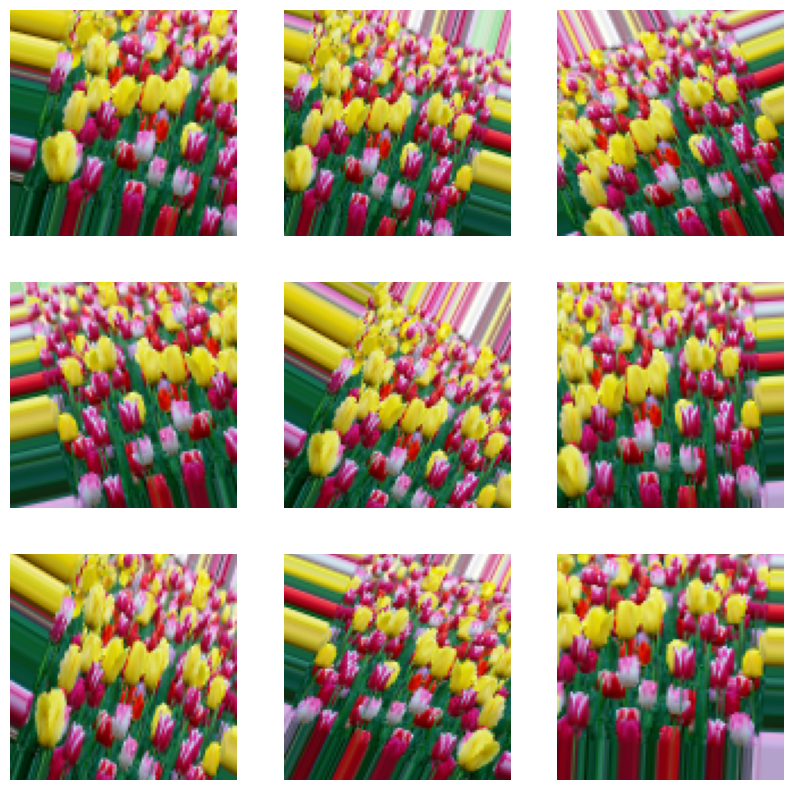

In [139]:
dgen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

B = test_gen.next()[0][0]
B = B[np.newaxis, :, :, :]

gen2 = dgen.flow(B)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    A = gen2.next()
    A = A.squeeze()
    A = A - A.min()
    A = A / A.max() * 255
    plt.imshow(A.astype('int'))
    plt.axis('off')